In [1]:
from importlib import reload
import pandas as pd
import numpy as np
# Plotting tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# Stats analysis tools
from scipy.stats import shapiro
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
# byc modules
from byc import plotting
import byc.standard_analysis as sa
import byc.fitting_tools as ft
import byc.file_management as fm
import byc.database as db
import byc.trace_tools as tt
# Set styles
plotting.set_styles(plt, matplotlib)

reloads = [sa, ft, plotting,
           fm, db, tt]
for module in reloads:
    reload(module)
byc_database = db.byc_database
db_df = byc_database.trace_database_df
expt_names = db_df.expt_name.unique()
expt_names

array(['20191106_byc_by4741_young_NS',
       '20191223_byc_by4741_Rkk-Su9_pJC034',
       '20191213_byc_by4741_young_rkk-sp2_pJC033',
       '20190927_byc_rpn4d_young_ubl-yfp-ns_pJC010',
       '20190927_byc_rpn4d_old_ubl-yfp-ns_pJC010',
       '20190920_byc_pJC010_UbL_YFP_NS_pdr5d_old',
       '20191008_byc_pJC010_UbL_YFP_NS_pdr5d_young',
       '20191008_byc_pJC010_UbL_YFP_NS_ubr2d_young',
       '20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay'],
      dtype=object)

## Filter DsRed and look for peaks

C:\Users\John Cooper\Projects\byc\byc\plotting.py:306: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4, 3), tight_layout=True)
C:\Users\John Cooper\Projects\byc\byc\plotting.py:376: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(2.5, 2.5), tight_layout=True)


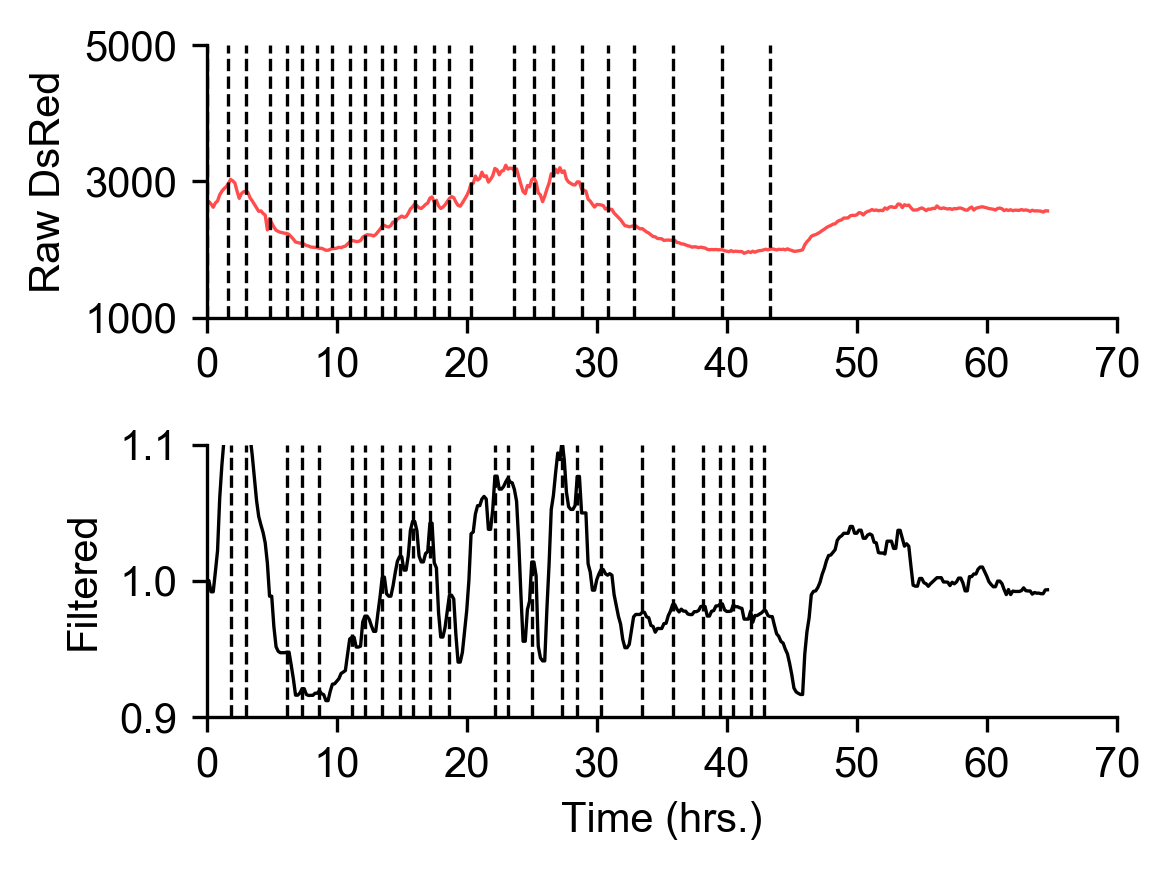

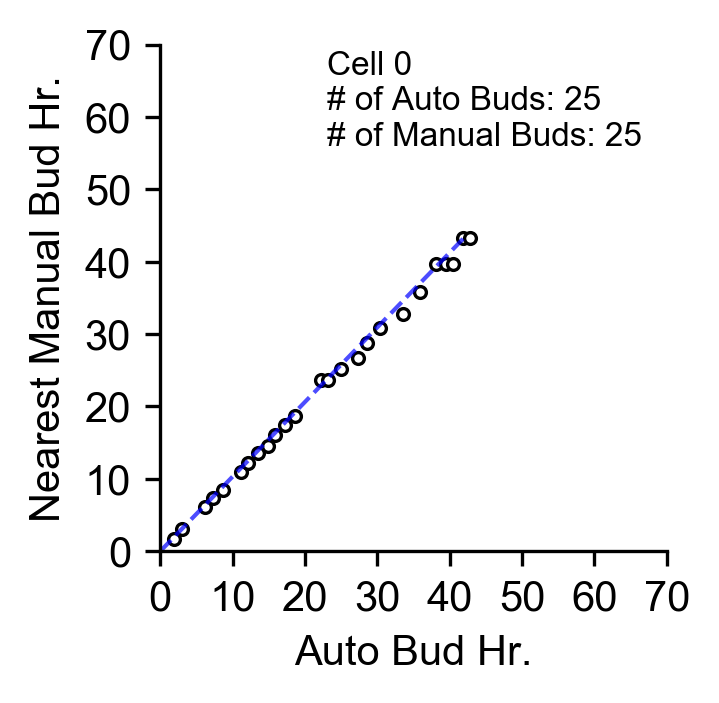

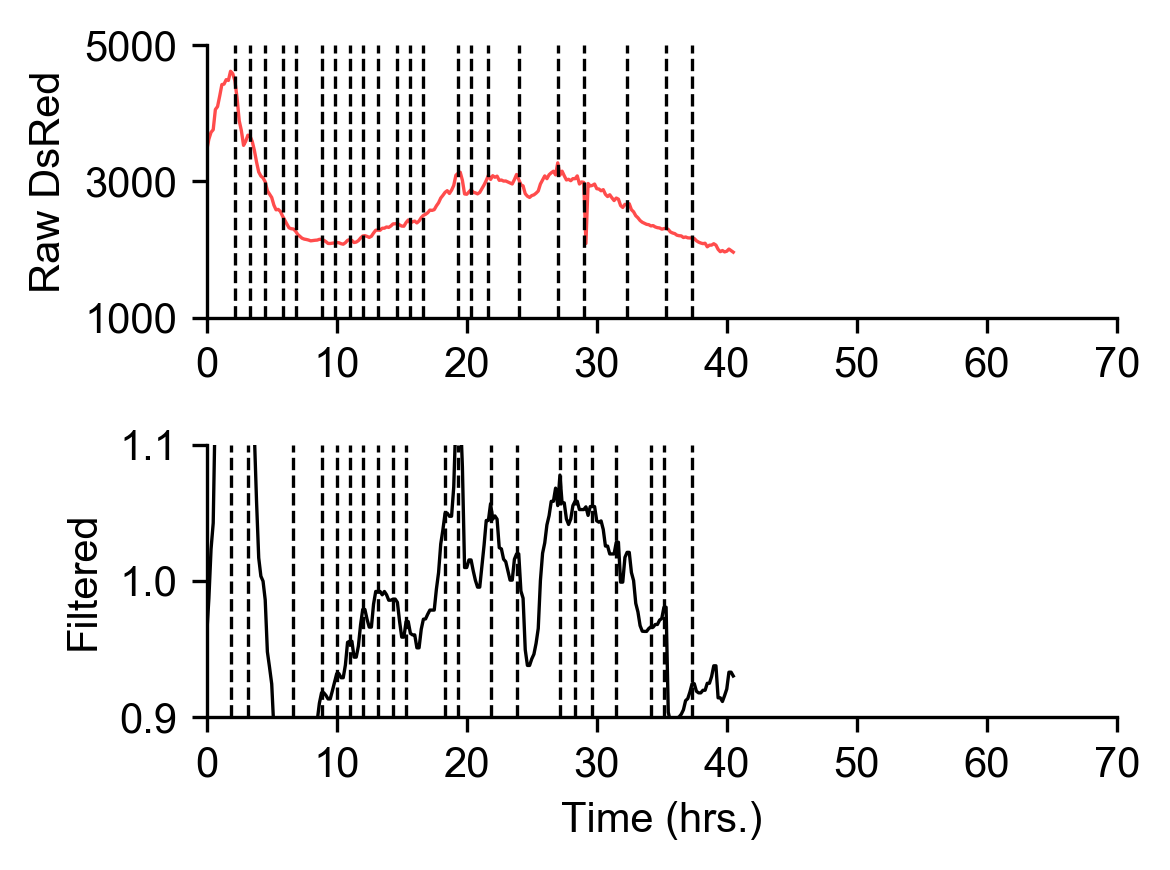

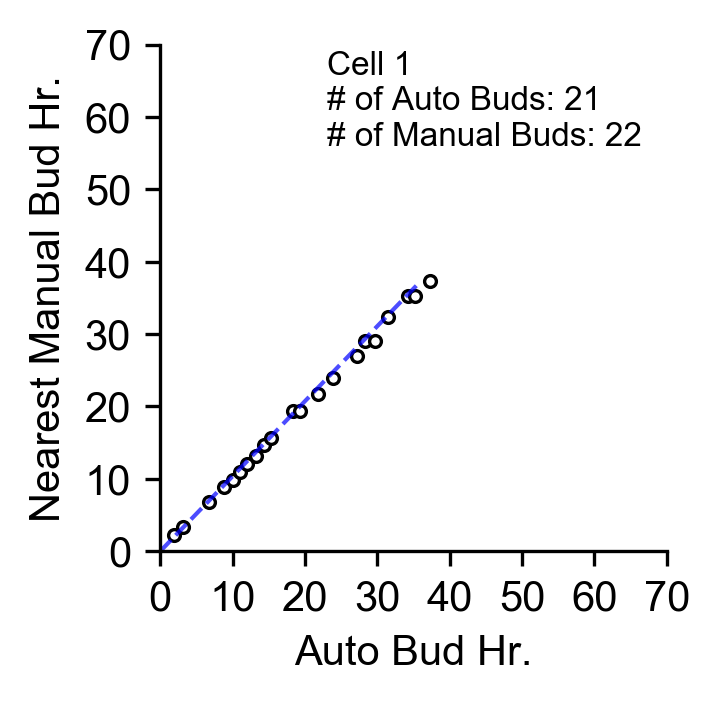

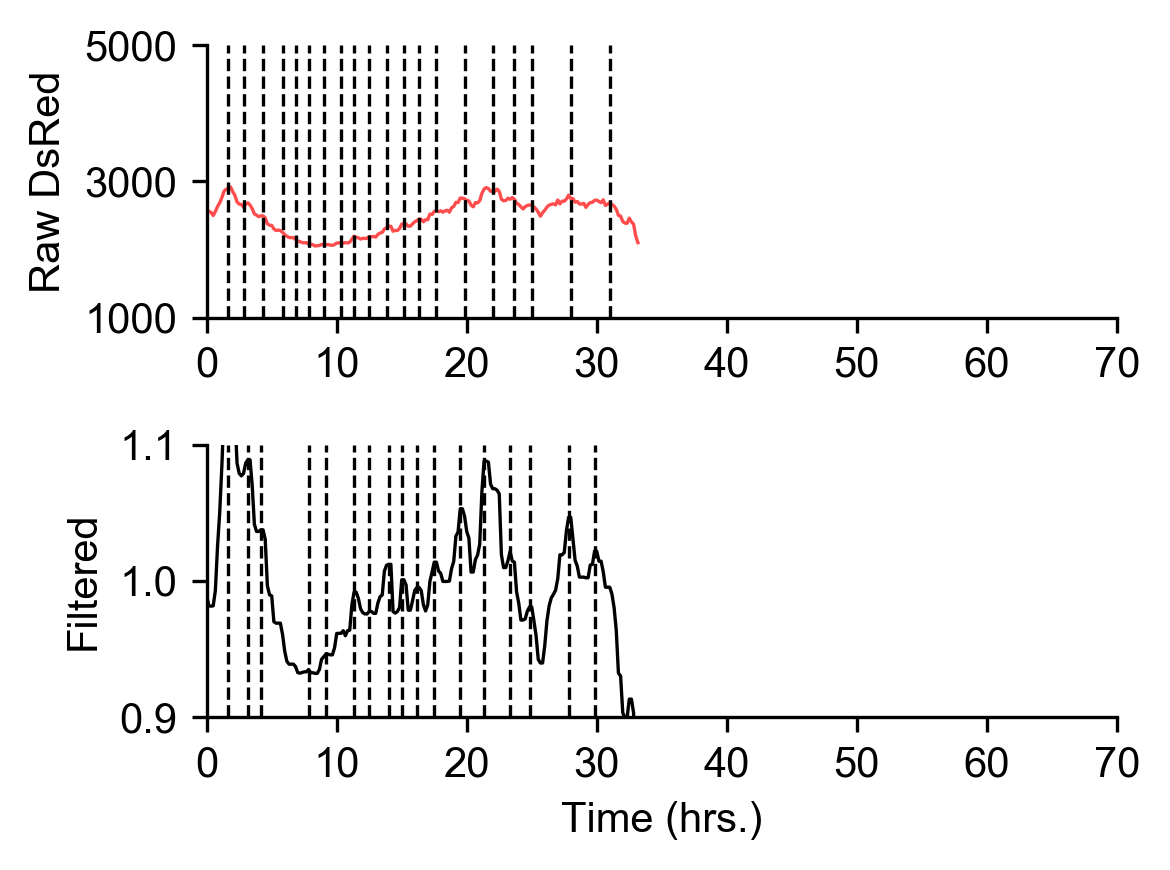

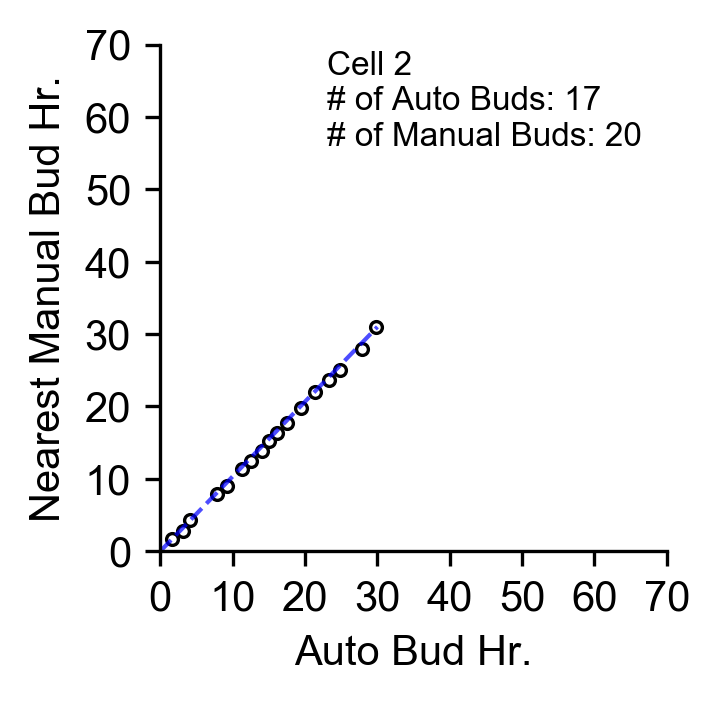

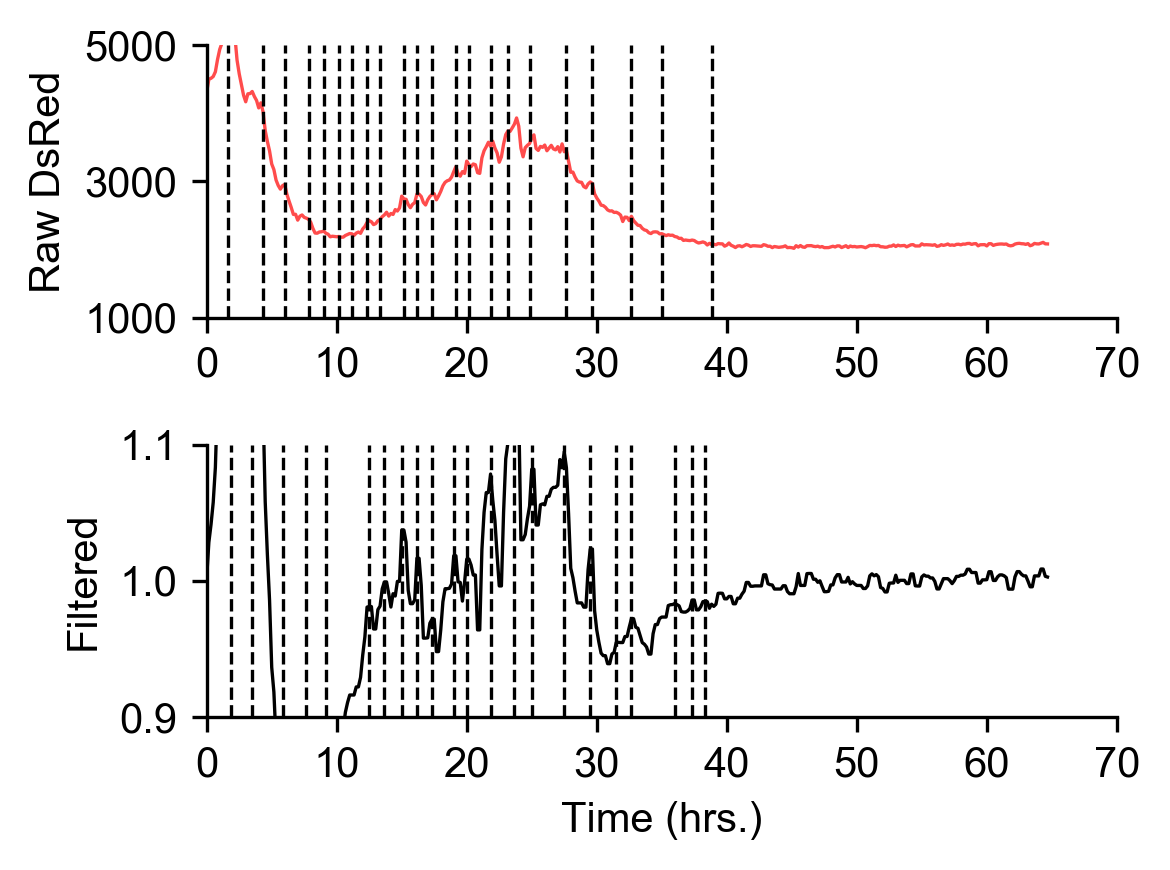

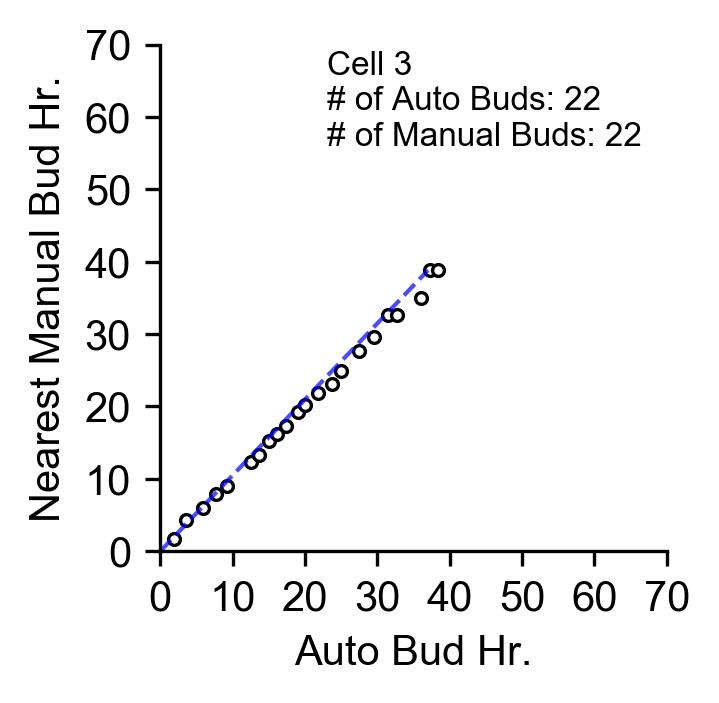

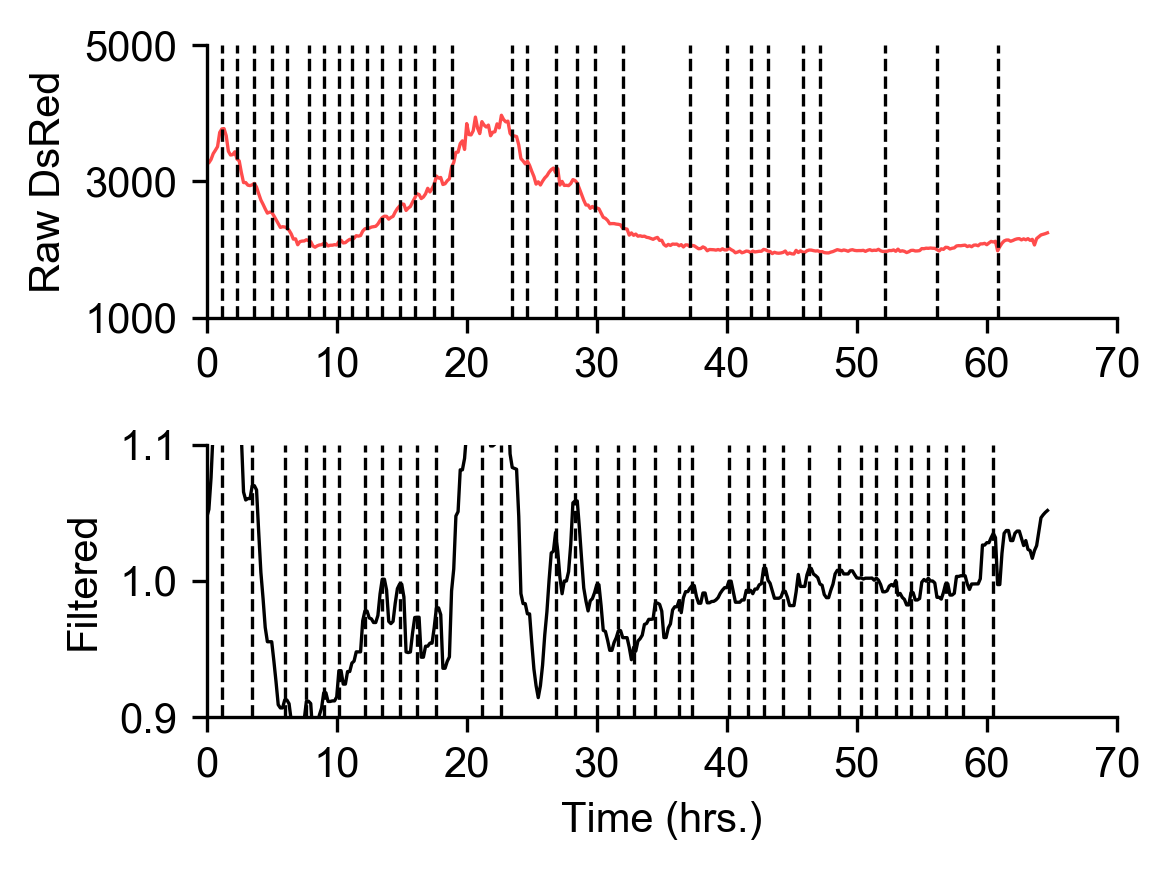

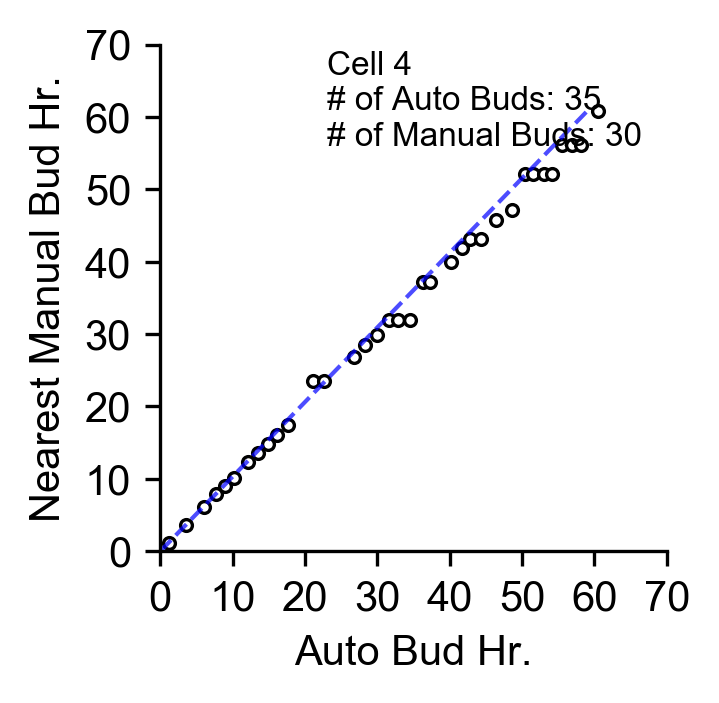

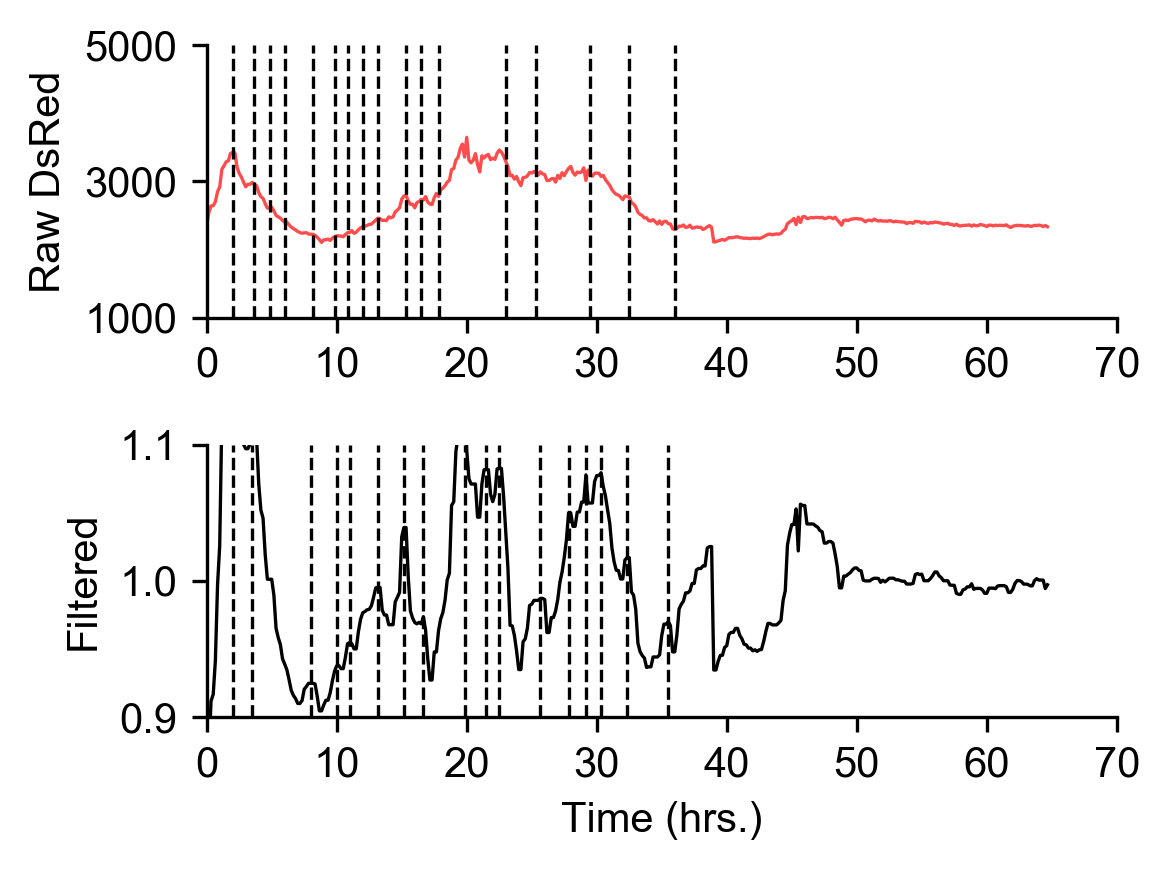

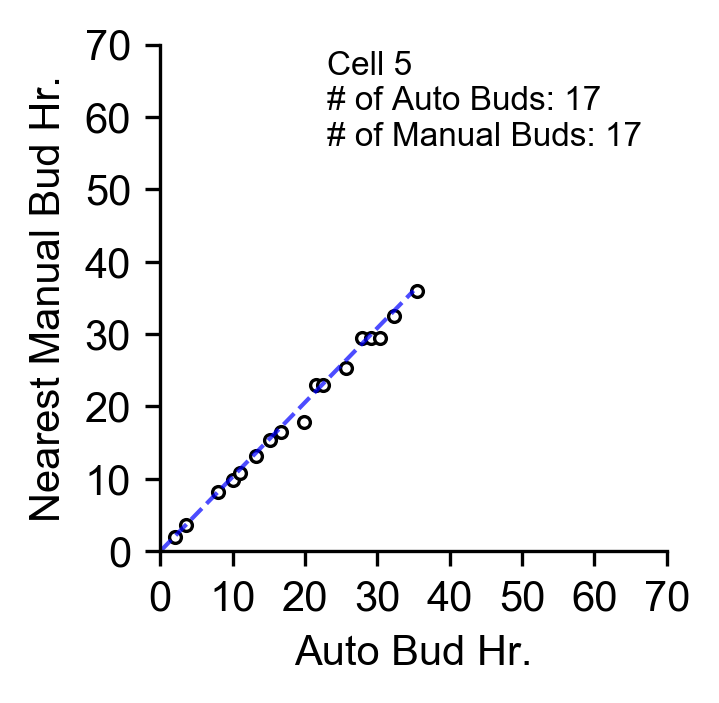

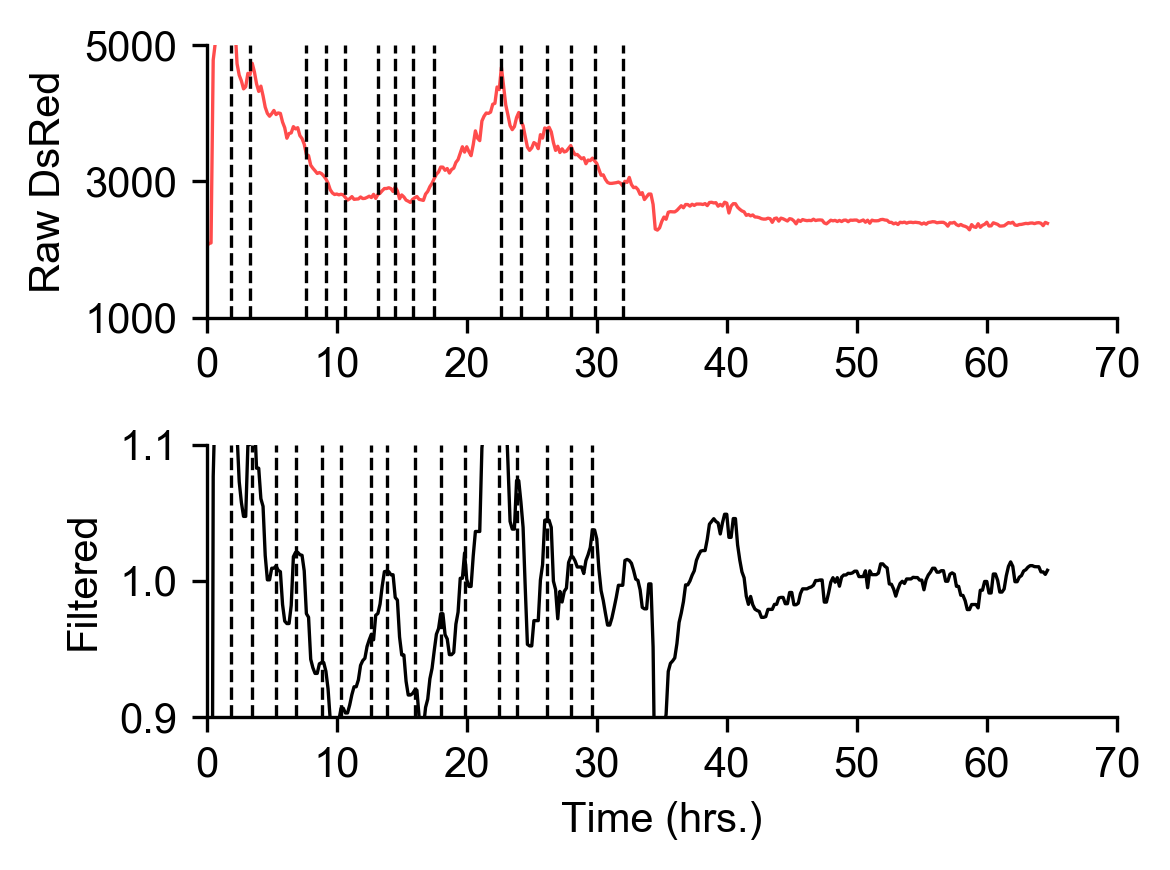

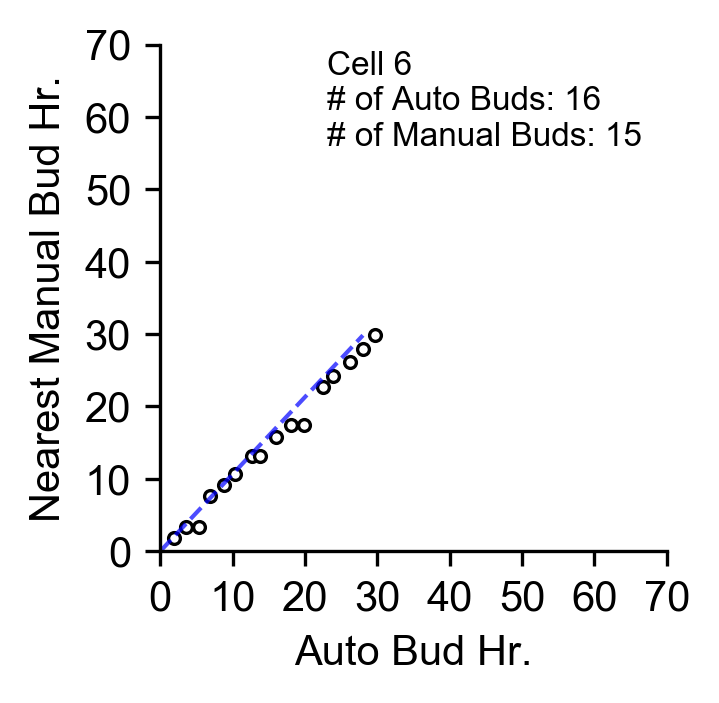

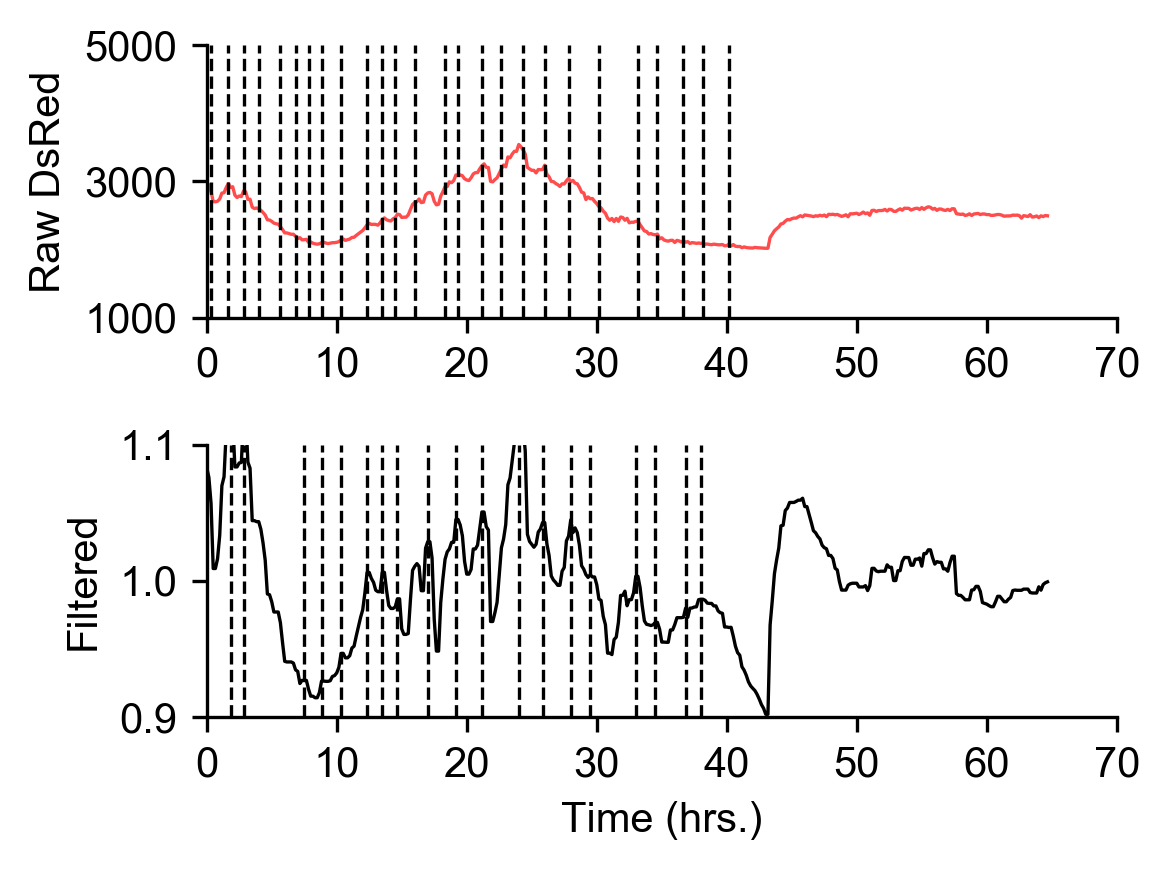

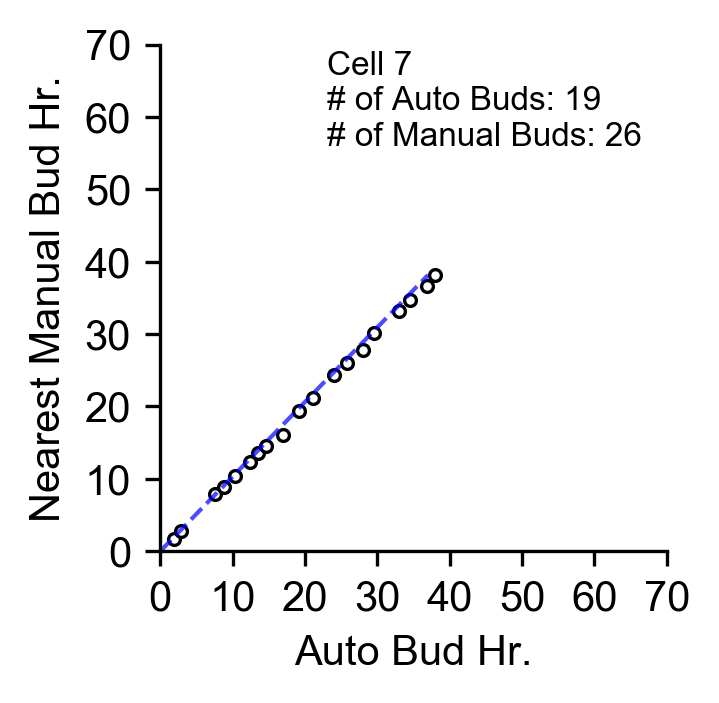

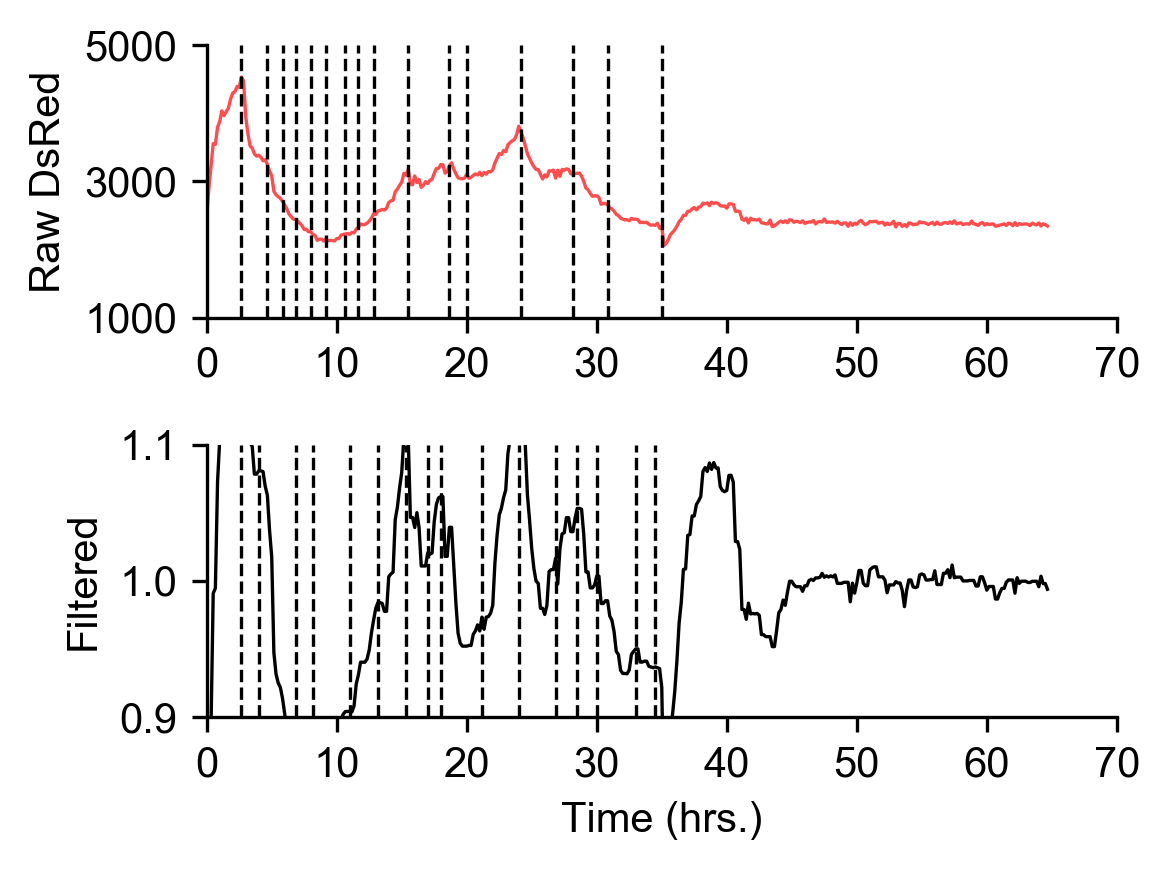

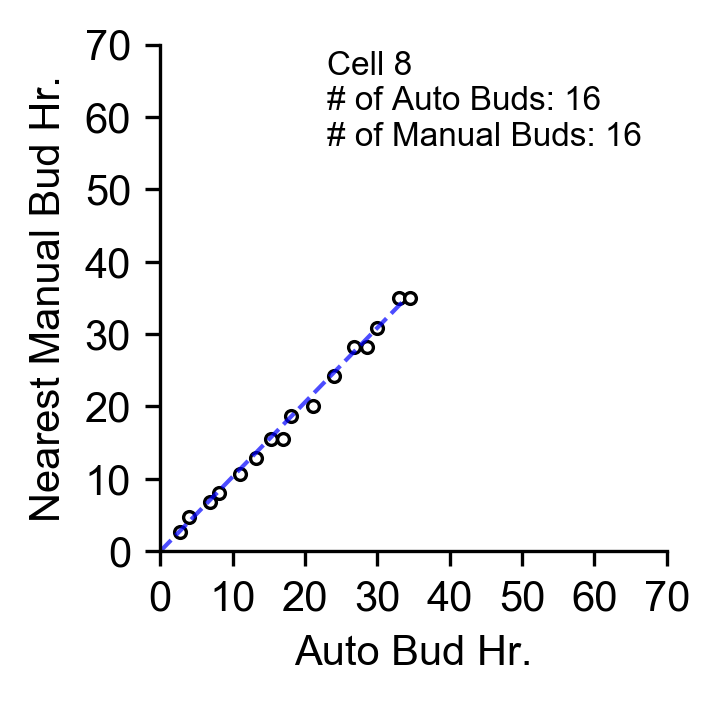

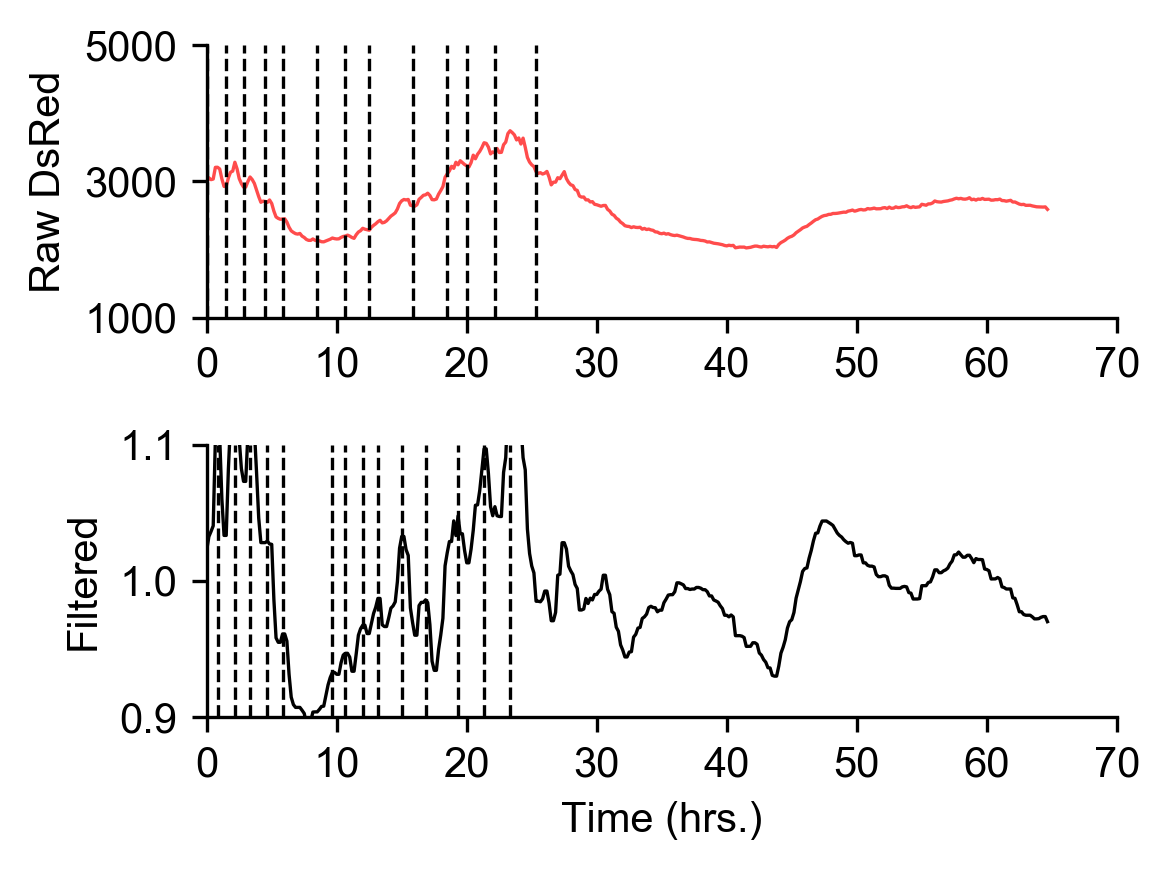

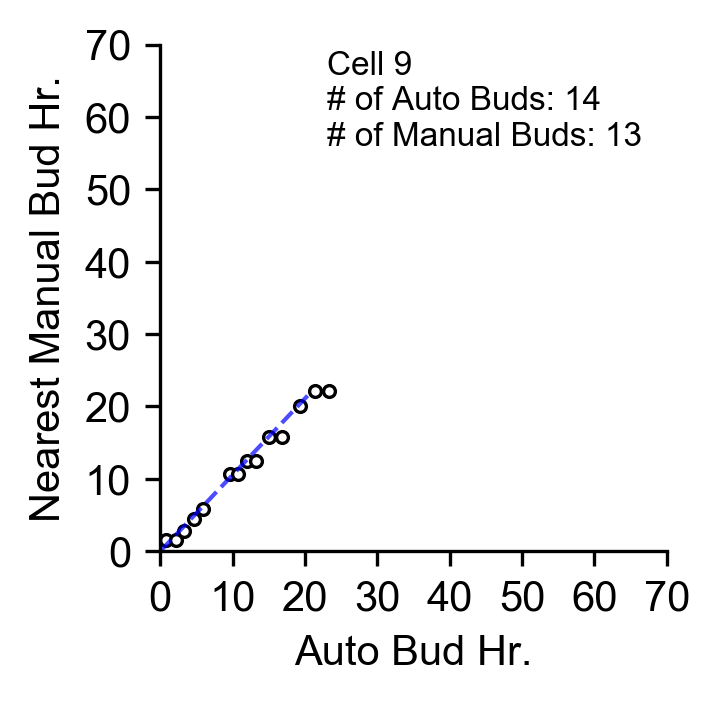

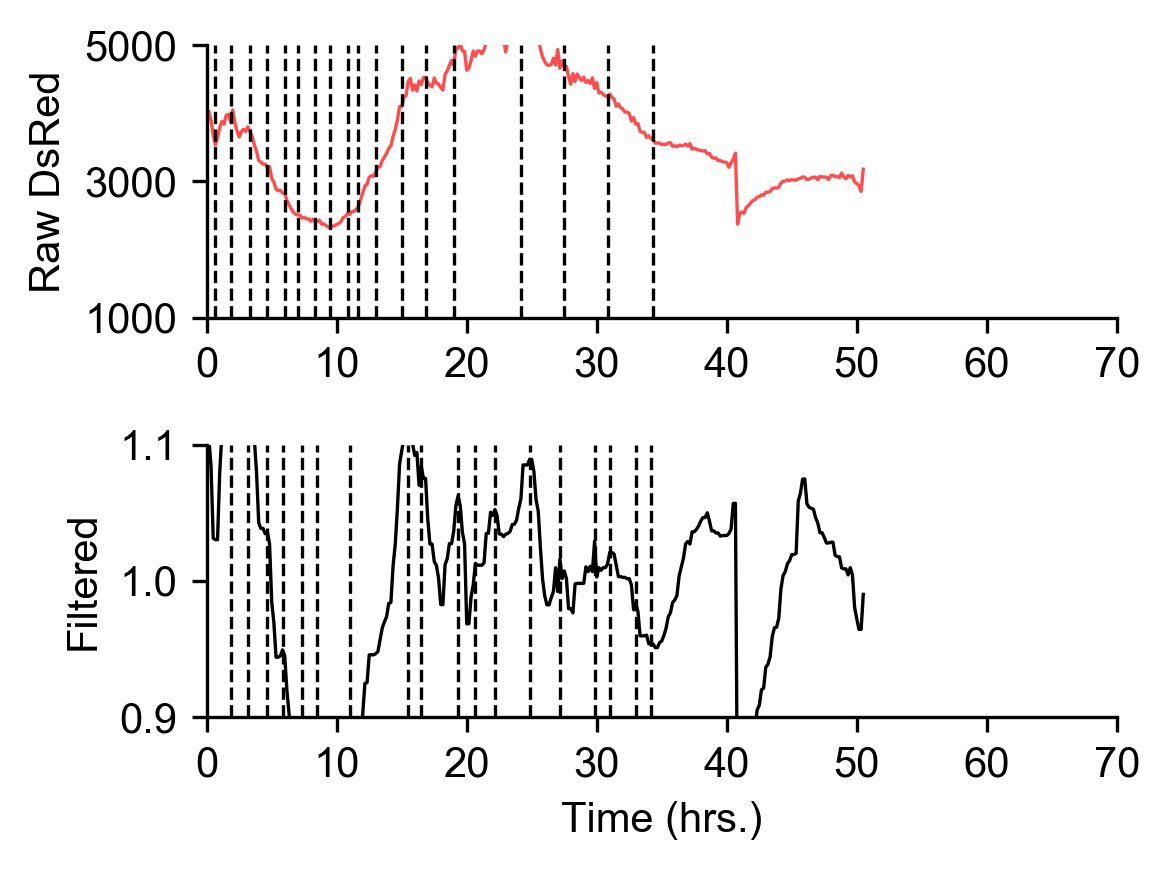

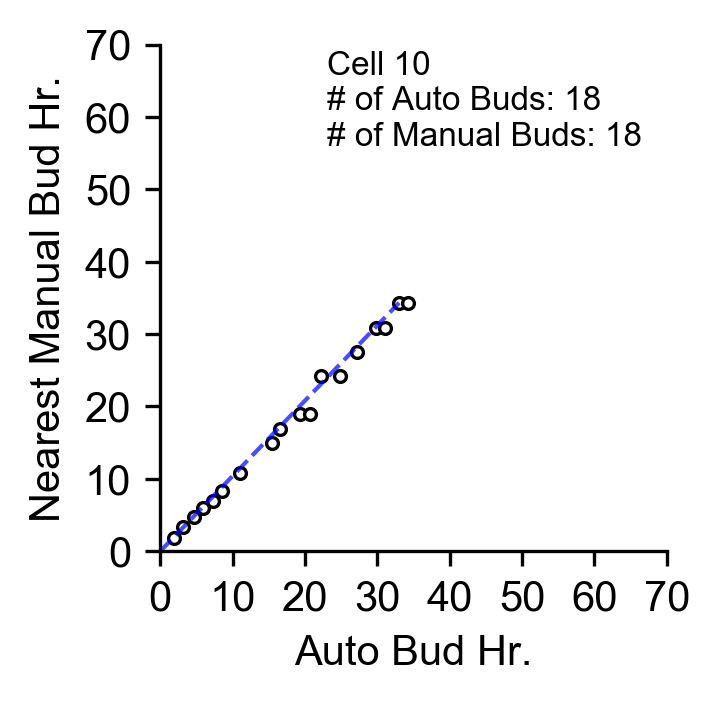

In [41]:
reload(tt)
reload(plotting)
# get traces from 20190726_byc, a long experiment
expt_name = "20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay"
dfs_list = byc_database.get_cell_trace_dfs(expt_name)
expt_date = '20190726'

neighbor_dfs = []

for cell_index in range(11):
    expt_df = byc_database.trace_database_df[byc_database.trace_database_df.expt_name == expt_name]
    path = expt_df.loc[expt_df.index[cell_index], 'bud_roi_path']
    manual_bud_indices = fm.read_roi_position_indices(path)
    min_cycle_frames = 6
    cell_df = dfs_list[cell_index]

    filtered_df = tt.add_filtered_columnns(cell_df, 'dsred_mean')

    peak_indices, peak_dict = find_peaks(filtered_df.dsred_mean_local_mean_norm_medfilt,
                                         distance=min_cycle_frames)

    plotting.plot_cell_peak_detection(filtered_df, peak_indices,
                                      manual_bud_indices=manual_bud_indices)
    
    neighbor_df = tt.make_bud_neighbor_df(manual_bud_indices, auto_bud_indices=peak_indices)    
    plotting.plot_auto_manual_corr(neighbor_df, cell_index, f'{expt_date}_byc')
    neighbor_dfs.append(neighbor_df)

## Plots of raw, local_mean_for norm (kernel_size=15), sliding mean filter (kernel_size=3-5), then ratio of sliding mean filtered to local mean 

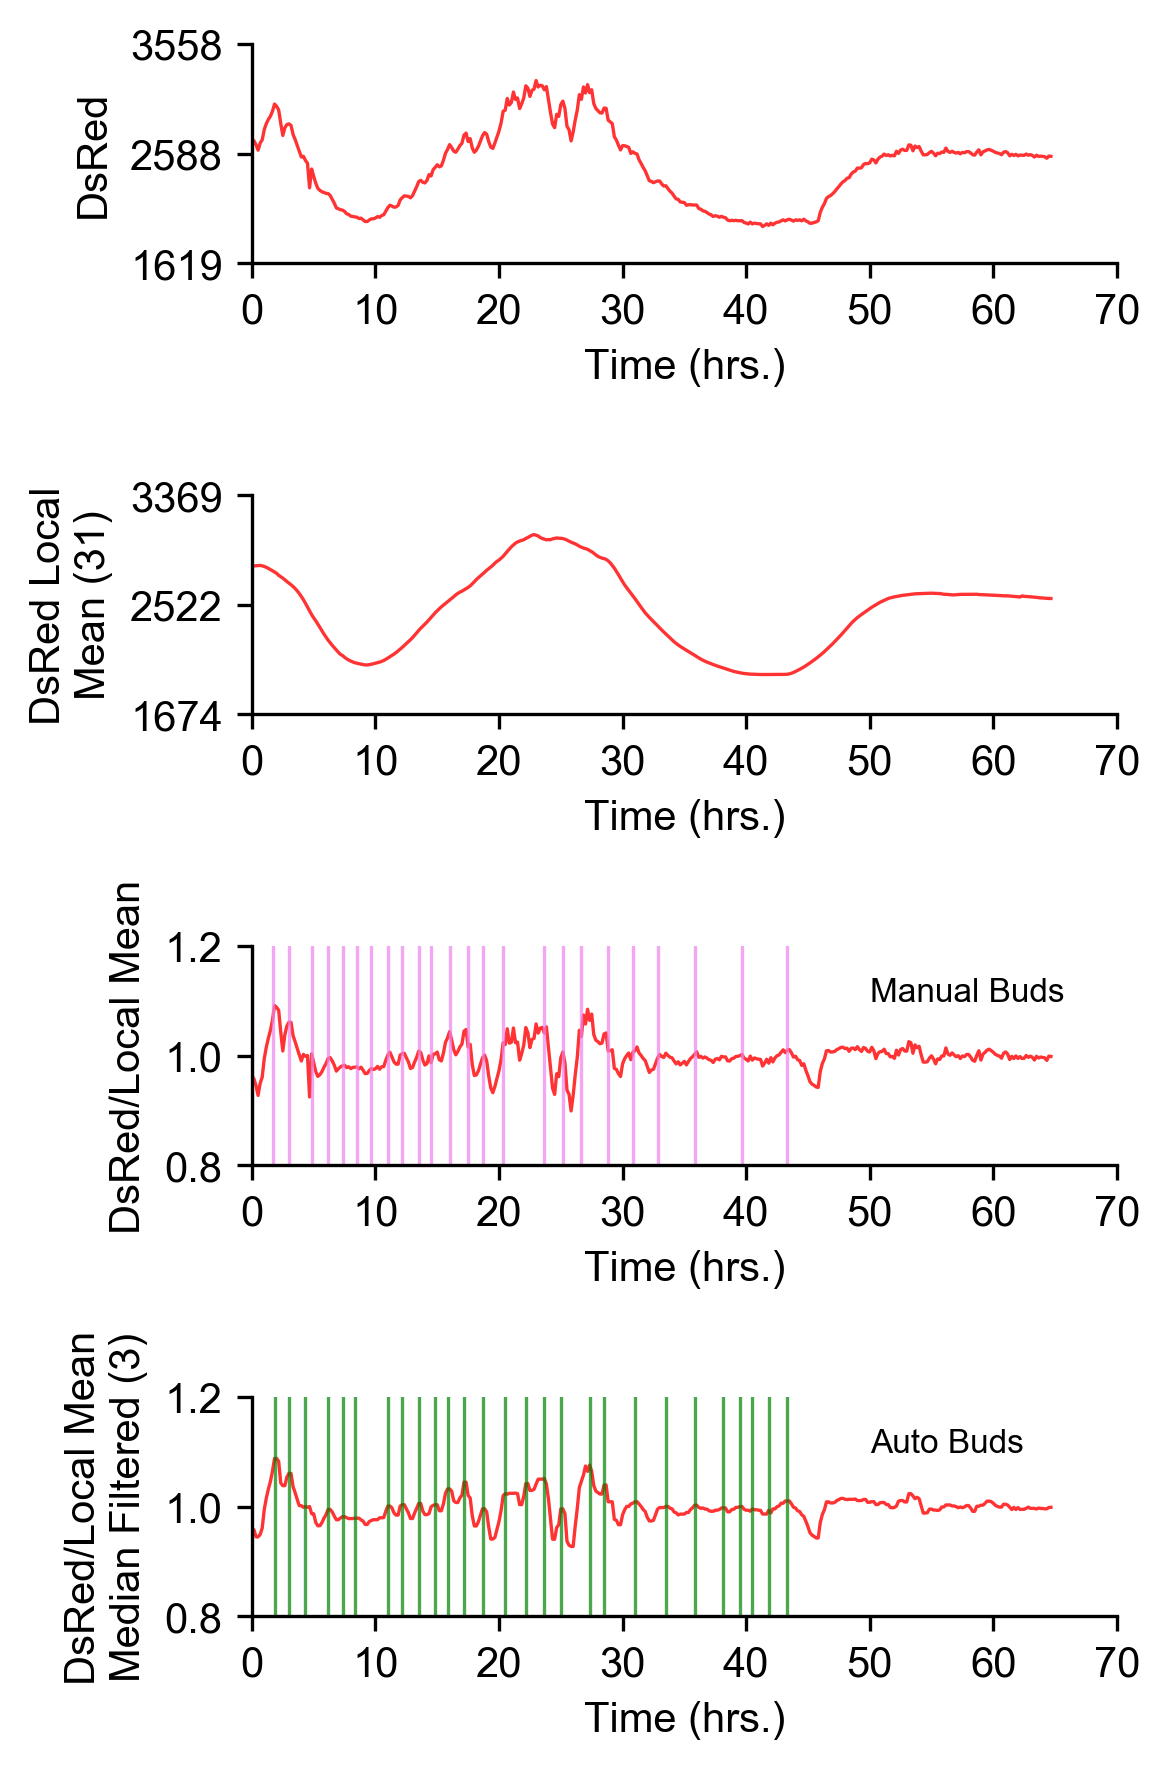

<Figure size 288x108 with 0 Axes>

<Figure size 288x108 with 0 Axes>

<Figure size 288x108 with 0 Axes>

<Figure size 288x108 with 0 Axes>

In [63]:
# get traces from 20190726_byc, a long experiment
expt_name = "20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay"
dfs_list = byc_database.get_cell_trace_dfs(expt_name)
cell_index = 0

expt_df = byc_database.trace_database_df[byc_database.trace_database_df.expt_name == expt_name]
path = expt_df.loc[expt_df.index[cell_index], 'bud_roi_path']
manual_bud_indices = fm.read_roi_position_indices(path)
min_cycle_frames = 6
cell_df = dfs_list[cell_index]
local_mean_kern = 31
medfilt_kern = 3

cell_df = tt.mean_filter(cell_df, 'dsred_mean', local_mean_kern, name_with_kernel=True)
cell_df.loc[:, 'local_mean_norm'] = cell_df.dsred_mean / cell_df.loc[:, f'dsred_mean_meanfilt_{local_mean_kern}']
cell_df = tt.median_filter(cell_df, 'local_mean_norm', meanfilt_kern, name_with_kernel=True)
peak_indices, peak_dict = find_peaks(cell_df.loc[:, f'local_mean_norm_medfilt_{medfilt_kern}'],
                                                 distance=min_cycle_frames)

reload(plotting)
fig = plt.figure(figsize=(4, 6), tight_layout=True)
fig.set_dpi(300)

ax1kwargs = {'tracecolor': 'red',
          'ylabel': 'DsRed',
          'xlim': (0, 70),
          'fig': fig}
ax1 = plotting.plot_fluor_trace(cell_df, 'dsred_mean', 411,
                               **ax1kwargs)

ax2kwargs = {'tracecolor': 'red',
          'ylabel': f'DsRed Local\nMean ({local_mean_kern})',
          'xlim': (0, 70),
          'fig': fig}
ax2 = plotting.plot_fluor_trace(cell_df, f'dsred_mean_meanfilt_{local_mean_kern}', 412,
                                **ax2kwargs)

ax3kwargs = {'tracecolor': 'red',
          'ylabel': f'DsRed/Local Mean',
          'xlim': (0, 70),
          'ylim': (0.8, 1.2),
          'fig': fig}
ax3 = plotting.plot_fluor_trace(cell_df, 'local_mean_norm', 413,
                                **ax3kwargs)

ax4kwargs = {'tracecolor': 'red',
          'ylabel': f'DsRed/Local Mean\nMedian Filtered ({medfilt_kern})',
          'xlim': (0, 70),
          'ylim': (0.8, 1.2),
          'fig': fig}

ax4 = plotting.plot_fluor_trace(cell_df, f'local_mean_norm_medfilt_{medfilt_kern}', 414,
                                **ax4kwargs)


ax3.annotate('Manual Buds', xy=(50, 1.1), fontsize=8)
for frame in manual_bud_indices:
    x_value = (frame*10)/60
    ax3.axvline(x_value, color='violet', alpha=0.7, linewidth=0.8)

ax4.annotate('Auto Buds', xy=(50, 1.1), fontsize=8)
for frame in peak_indices:
    x_value = (frame*10)/60
    if x_value <= np.max((manual_bud_indices*10)/60):
        ax4.axvline(x_value, color='green', alpha=0.7, linewidth=0.8,)

for a in [ax1, ax2, ax3, ax4]:
    a.set_xticks(np.linspace(0, 70, 8))
    
fig.savefig(f'20190726_Filtering_Workflow_cell{cell_index}.png')

In [140]:
find_peaks?

In [182]:
for threshold in np.linspace(0, 0.0001, 20):
    print(threshold)

0.0
5.263157894736842e-06
1.0526315789473684e-05
1.5789473684210526e-05
2.105263157894737e-05
2.6315789473684212e-05
3.157894736842105e-05
3.6842105263157895e-05
4.210526315789474e-05
4.736842105263158e-05
5.2631578947368424e-05
5.789473684210527e-05
6.31578947368421e-05
6.842105263157895e-05
7.368421052631579e-05
7.894736842105263e-05
8.421052631578948e-05
8.947368421052632e-05
9.473684210526316e-05
0.0001


In [198]:
# Starting to scan parameter space to see its effect on 
# how many peaks are found etc.
dfs = []
for threshold in np.linspace(0, 0.001, 20):
    print(threshold, end='\r')
    peak_indices, peak_dict = find_peaks(cell_df.local_mean_norm_medfilt_5,
                                             distance=min_cycle_frames, threshold=threshold)
    peak_indices = peak_indices[peak_indices <= np.max(manual_bud_indices)]
    df = pd.DataFrame({'peak_indices': peak_indices,
                       'threshold': threshold,
                       'n_peaks': len(peak_indices)})
    
    dfs.append(df)
    
peaks_df = pd.concat(dfs, ignore_index=True)
peaks_gb = peaks_df.groupby(by='threshold').median()

In [211]:
np.linspace(1, 10, 9)

array([ 1.   ,  2.125,  3.25 ,  4.375,  5.5  ,  6.625,  7.75 ,  8.875,
       10.   ])

### Varying peak distance and relative height threshold

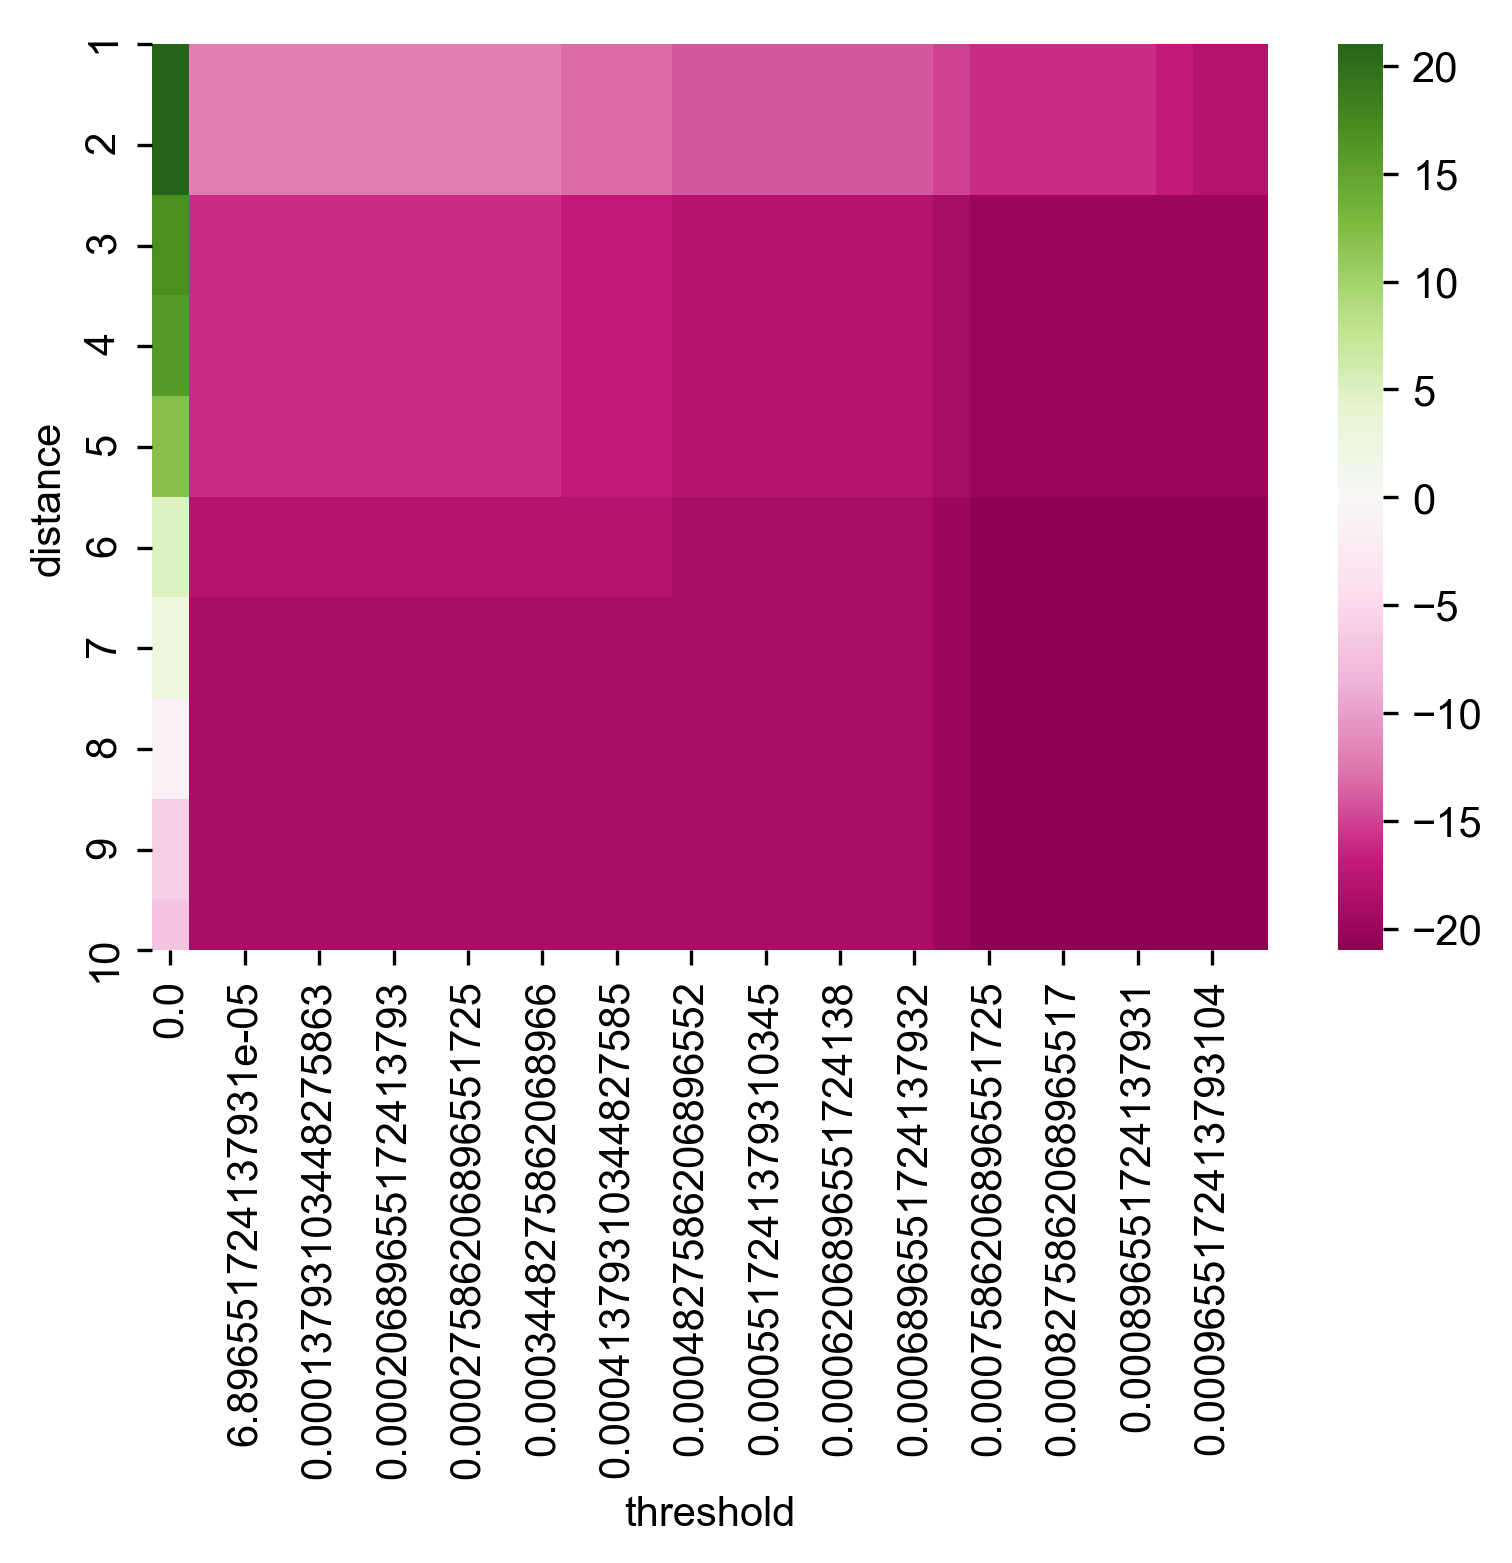

In [280]:
# get traces from 20190726_byc, a long experiment
expt_name = "20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay"
dfs_list = byc_database.get_cell_trace_dfs(expt_name)
cell_index = 4

expt_df = byc_database.trace_database_df[byc_database.trace_database_df.expt_name == expt_name]
path = expt_df.loc[expt_df.index[cell_index], 'bud_roi_path']
manual_bud_indices = fm.read_roi_position_indices(path)
cell_df = dfs_list[cell_index]
local_mean_kern = 31
filt_kern = 3

cell_df = tt.mean_filter(cell_df, 'dsred_mean', local_mean_kern, name_with_kernel=True)
cell_df.loc[:, 'local_mean_norm'] = cell_df.dsred_mean / cell_df.loc[:, f'dsred_mean_meanfilt_{local_mean_kern}']
cell_df = tt.median_filter(cell_df, 'local_mean_norm', filt_kern, name_with_kernel=True)

# Starting to scan parameter space to see its effect on 
# how many peaks are found etc.
dfs = []
for distance in range(1,11):
    for threshold in np.linspace(0, 0.001, 30):
    
        peak_indices, peak_dict = find_peaks(cell_df.loc[:, f'local_mean_norm_medfilt_{filt_kern}'],
                                             distance=distance,
                                             threshold=threshold)
        peak_indices = peak_indices[peak_indices <= np.max(manual_bud_indices)]
        df = pd.DataFrame({'peak_indices': peak_indices,
                           'distance': distance,
                           'threshold': threshold,
                           'n_peaks': len(peak_indices),
                           'delta': len(peak_indices) - len(manual_bud_indices)})

        dfs.append(df)
    
peaks_df = pd.concat(dfs, ignore_index=True)

heatmap_data = pd.pivot_table(peaks_df, values='delta',
                              index=['distance'],
                              columns='threshold')
fig = plt.figure()
fig.set_dpi(300)
ax = fig.add_subplot()
sns.heatmap(heatmap_data, cmap='PiYG', ax=ax)

### Varying local mean kernel size and sliding median kernel size

In [32]:
cell_df.cell_index.unique()[0]

1

In [34]:
# get traces from 20190726_byc, a long experiment
expt_name = "20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay"
dfs_list = byc_database.get_cell_trace_dfs(expt_name)
expt_df = byc_database.trace_database_df[byc_database.trace_database_df.expt_name == expt_name]

local_mean_kern_ll = 31
local_mean_kern_ul = 71
med_filt_kern_ll = 3
med_filt_kern_ul = 11
threshold = 0
distance = 6
dfs_list = dfs_list[:]
peaks_dfs = []
for i in range(len(dfs_list)):
    cell_df = dfs_list[i]
    cell_index = cell_df.cell_index.unique()[0]
    path = expt_df.loc[expt_df.index[cell_index], 'bud_roi_path']
    manual_bud_indices = fm.read_roi_position_indices(path)    
    # Starting to scan parameter space to see its effect on 
    # how many peaks are found etc.
    dfs = []
    combination_i = 1
    for local_mean_kern in range(local_mean_kern_ll, local_mean_kern_ul, 2):
        
        for filt_kern in range(med_filt_kern_ll, med_filt_kern_ul, 2):
            
            n_local_mean_kern = len(range(local_mean_kern_ll, local_mean_kern_ul, 2))
            n_med_filt_kern = len(range(med_filt_kern_ll, med_filt_kern_ul, 2))
            total_combs =  n_local_mean_kern*n_med_filt_kern
            print(f'Scanning params combination {combination_i}/{total_combs} for cell {cell_index+1}/{len(dfs_list)}',
                  end='\r')
            
            cell_df = tt.mean_filter(cell_df, 'dsred_mean', local_mean_kern, name_with_kernel=True)
            cell_df.loc[:, 'local_mean_norm'] = cell_df.dsred_mean / cell_df.loc[:, f'dsred_mean_meanfilt_{local_mean_kern}']
            cell_df = tt.median_filter(cell_df, 'local_mean_norm', filt_kern, name_with_kernel=True)

            peak_indices, peak_dict = find_peaks(cell_df.loc[:, f'local_mean_norm_medfilt_{filt_kern}'],
                                                 distance=distance,
                                                 threshold=threshold)
            peak_indices = peak_indices[peak_indices <= np.max(manual_bud_indices)]
            delta = len(peak_indices) - len(manual_bud_indices)
            norm_delta = delta/len(manual_bud_indices)
            df = pd.DataFrame({'cell_index': cell_index,
                               'peak_indices': peak_indices,
                               'local_mean_kern': local_mean_kern,
                               'filt_kern': filt_kern,
                               'n_peaks': len(peak_indices),
                               'delta': delta,
                               'norm_delta': norm_delta})
            # Essentially collapse the peak_indices column and keep all the single
            # number summary outputs.
            df = df.groupby(by=['local_mean_kern', 'filt_kern'], as_index=False).median()
            dfs.append(df)
            combination_i += 1
    peaks_df = pd.concat(dfs, ignore_index=True)
    peaks_dfs.append(peaks_df)

In [64]:
all_peaks_df = pd.concat(peaks_dfs, ignore_index=True)
all_peaks_gb = all_peaks_df.groupby(by=['local_mean_kern', 'filt_kern'], as_index=False)
all_peaks_med = all_peaks_gb.sum()
all_peaks_med.head()

,local_mean_kern,filt_kern,cell_index,peak_indices,n_peaks,delta,norm_delta
0,31,3,55.0,1203.0,237.0,13.0,0.742173
1,31,5,55.0,1175.5,207.0,-17.0,-0.797196
2,31,7,55.0,1335.5,157.0,-67.0,-3.329047
3,31,9,55.0,1229.5,146.0,-78.0,-3.804695
4,33,3,55.0,1207.0,238.0,14.0,0.780961


In [358]:
all_peak_scans_df = pd.concat(peaks_dfs, ignore_index=True)
all_peak_scans_df.to_csv('all_peak_scans_df.csv', index=False)

[Text(0, 0.5, '31'),
 Text(0, 2.5, '35'),
 Text(0, 4.5, '39'),
 Text(0, 6.5, '43'),
 Text(0, 8.5, '47'),
 Text(0, 10.5, '51'),
 Text(0, 12.5, '55'),
 Text(0, 14.5, '59'),
 Text(0, 16.5, '63'),
 Text(0, 18.5, '67')]

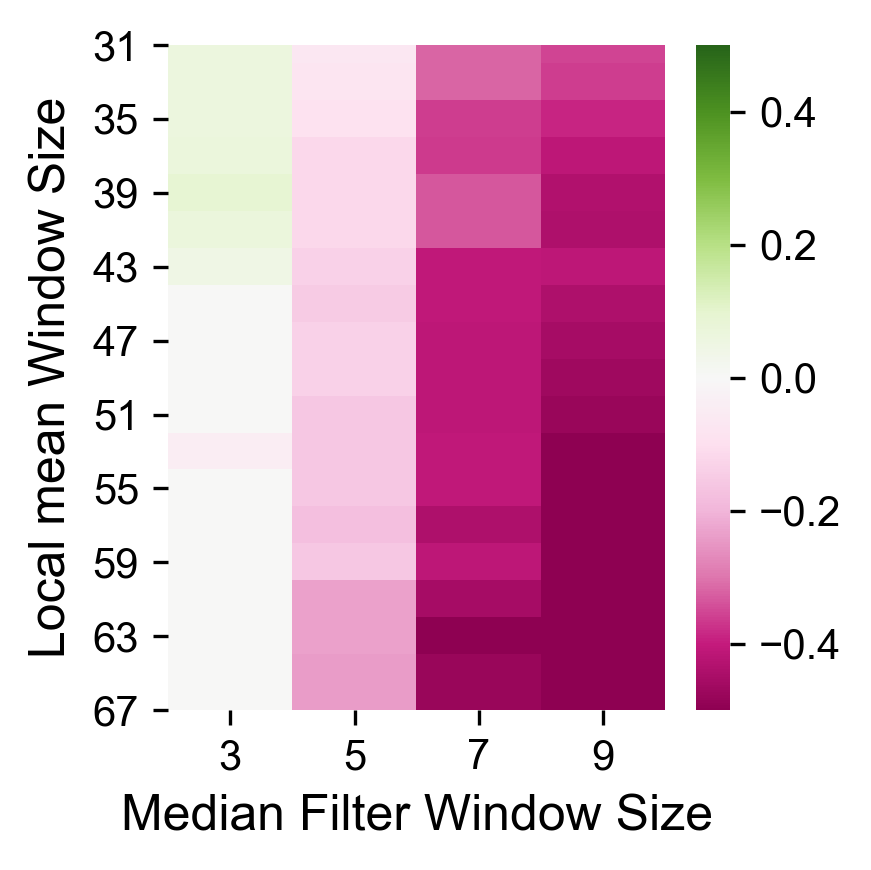

In [38]:
fig = plt.figure(figsize=(3, 3), tight_layout=True)
fig.set_dpi(300)
ax = fig.add_subplot(111)

heatmap_data = pd.pivot_table(all_peaks_med, values='norm_delta',
                              index=['local_mean_kern'],
                              columns='filt_kern')
              
sns.heatmap(heatmap_data, cmap='PiYG', ax=ax,
            center=0, vmin=-0.5, vmax=0.5)

ax.set_ylabel("Local mean Window Size", fontsize=12)
ax.set_xlabel("Median Filter Window Size", fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

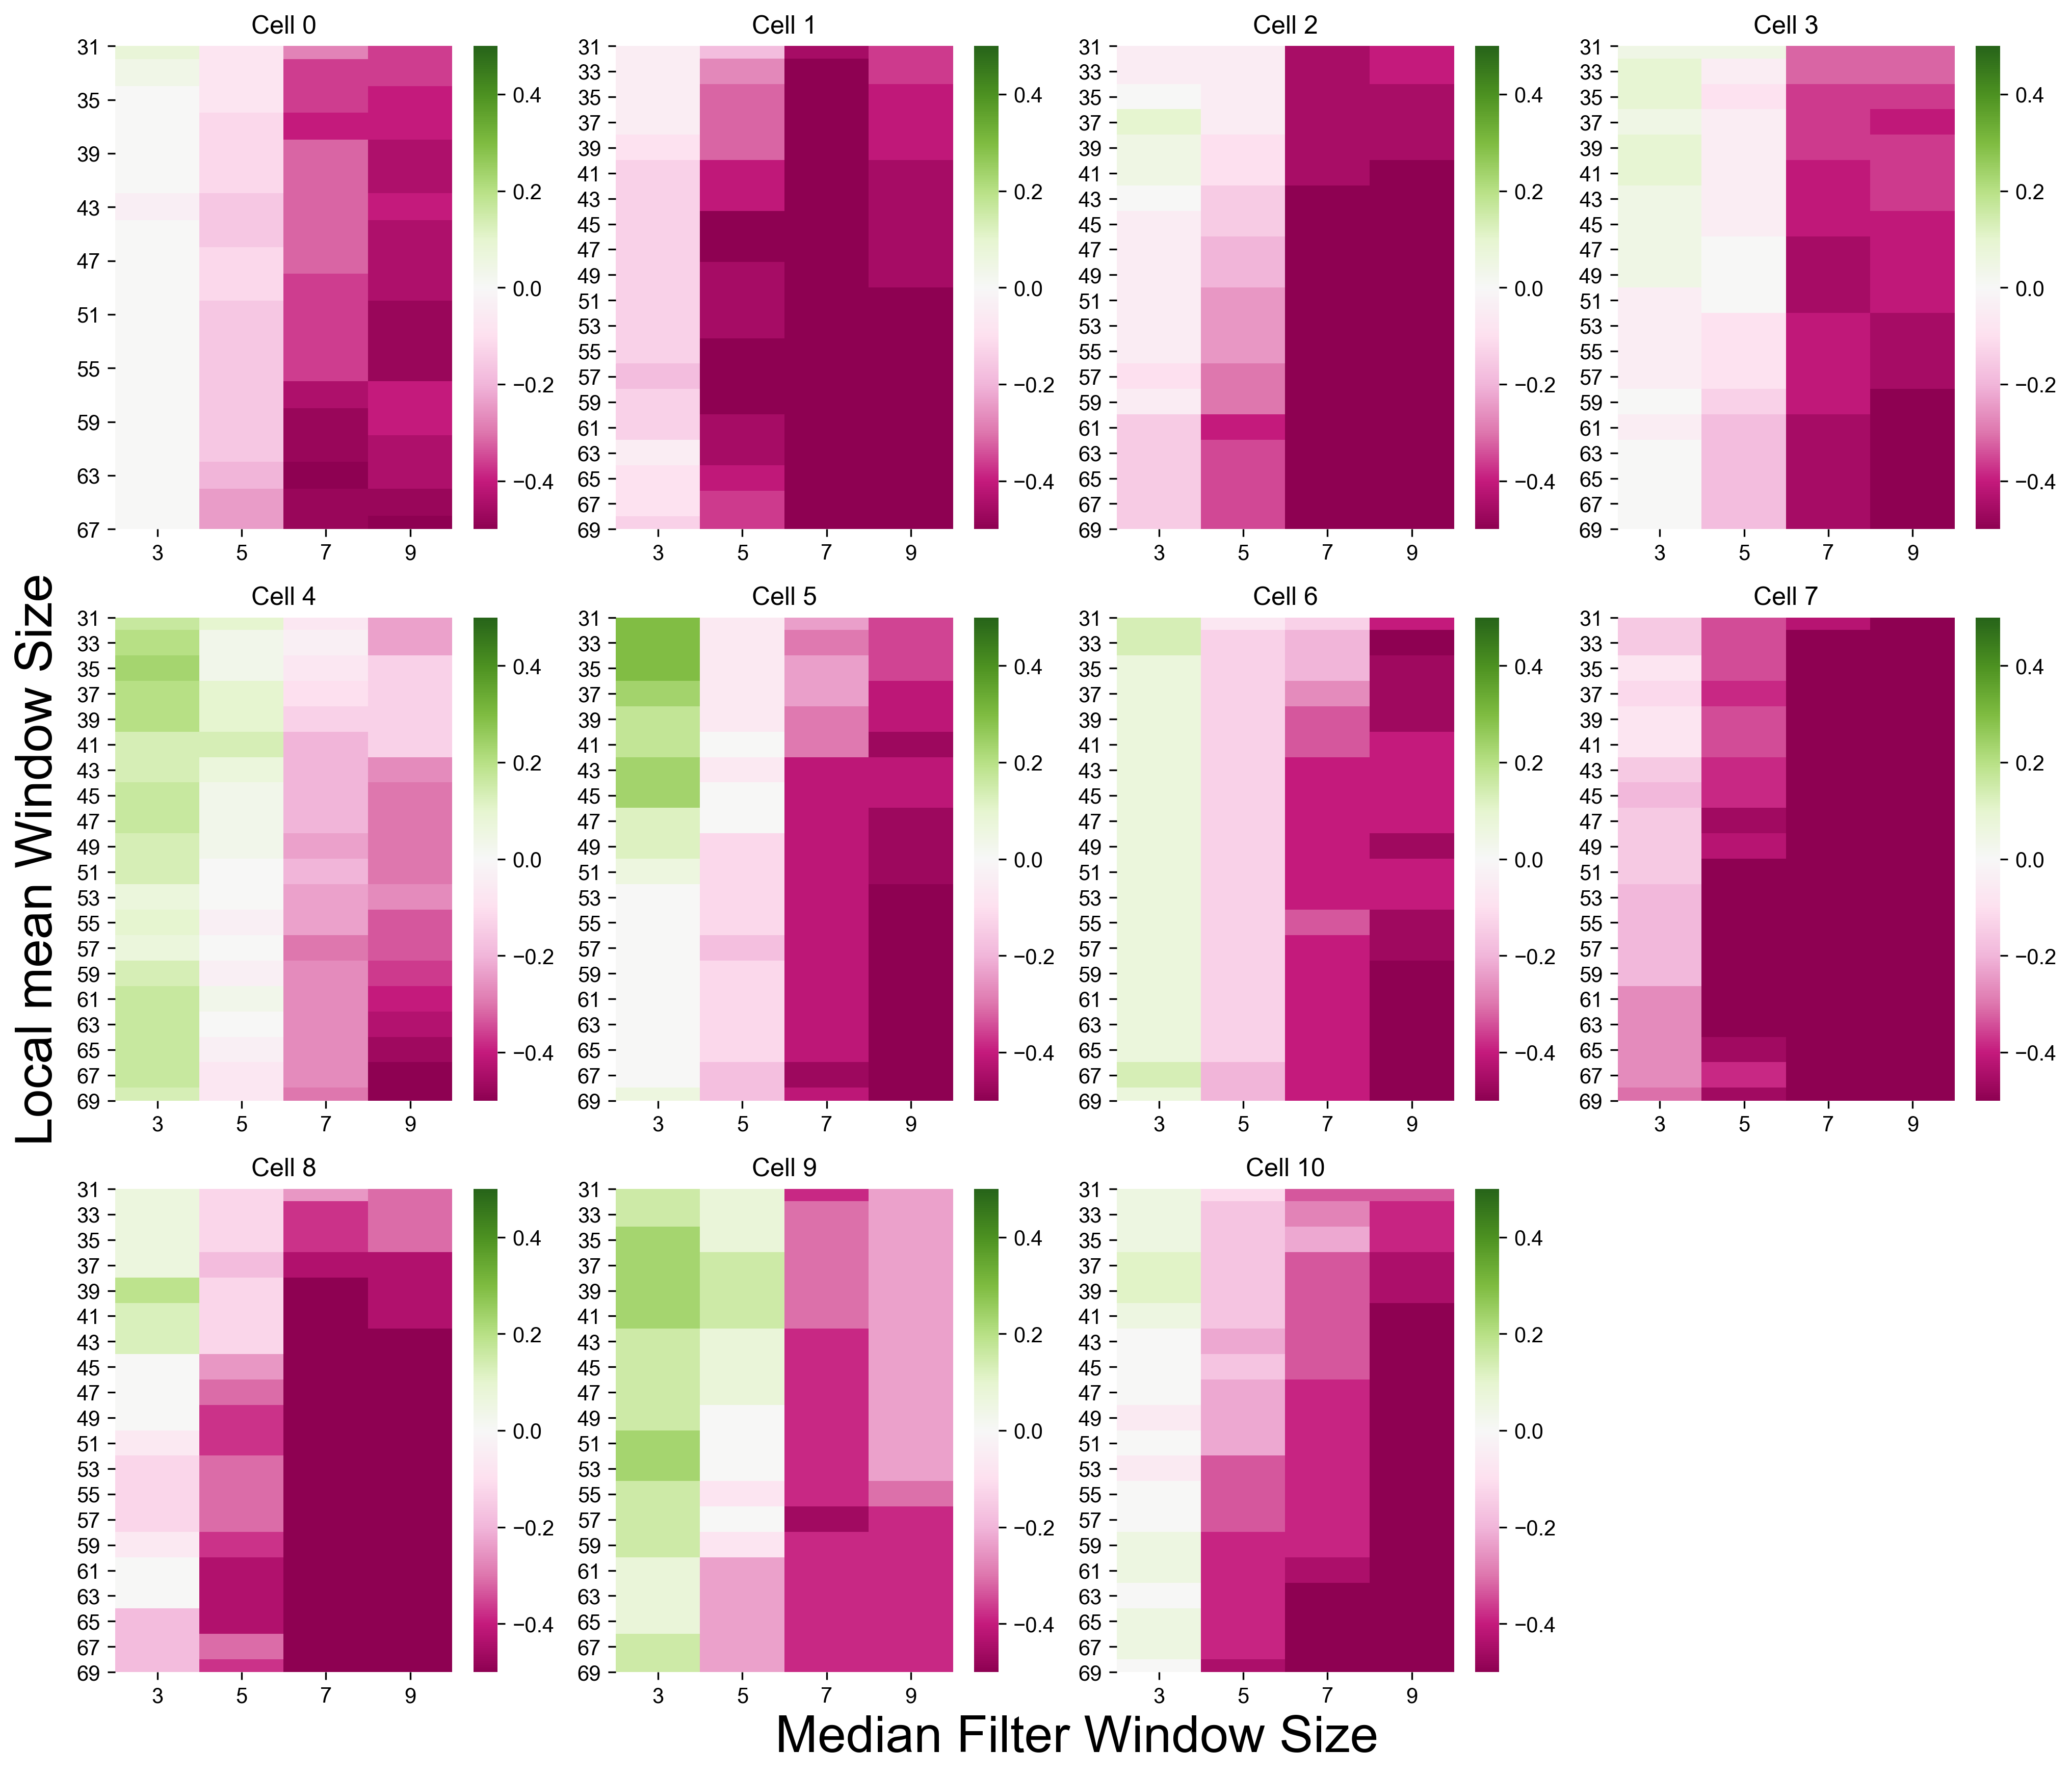

In [49]:
fig = plt.figure(figsize=(14, 12), tight_layout=True)
fig.set_dpi(300)

ax = fig.add_subplot(111)
for spine_name in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine_name].set_visible(False)
ax.set_ylabel("Local Mean Window Size", fontsize=24)
ax.set_xlabel("Median Filter Window Size", fontsize=24)
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

pivot_tables = []
for cell_index in range(len(dfs_list)):
    peaks_df = peaks_dfs[cell_index]
    heatmap_data = pd.pivot_table(peaks_df, values='norm_delta',
                                  index=['local_mean_kern'],
                                  columns='filt_kern')
    pivot_tables.append(heatmap_data)
    subax = fig.add_subplot(3, 4, cell_index+1)
    sns.heatmap(heatmap_data, cmap='PiYG', ax=subax,
                center=0, vmin=-0.5, vmax=0.5)
    subax.set_title(f'Cell {cell_index}')
    subax.set_ylabel('')
    subax.set_yticklabels(subax.get_yticklabels(), rotation=0)
    subax.set_xlabel('')

In [ ]:
df = pd.DataFrame

In [359]:
all_peak_scans_gb = 

,cell_index,peak_indices,local_mean_kern,filt_kern,n_peaks,delta,norm_delta
1488,1,11,15,3,22,0,0.000000
1489,1,20,15,3,22,0,0.000000
1490,1,26,15,3,22,0,0.000000
1491,1,34,15,3,22,0,0.000000
1492,1,40,15,3,22,0,0.000000
...,...,...,...,...,...,...,...
2639,1,131,49,9,12,-10,-0.454545
2640,1,162,49,9,12,-10,-0.454545
2641,1,182,49,9,12,-10,-0.454545
2642,1,191,49,9,12,-10,-0.454545


In [335]:
# get traces from 20190726_byc, a long experiment
expt_name = "20190726_byc_pJC010_UBL-YFP-NS_pdr5d_young_old_decay"
dfs_list = byc_database.get_cell_trace_dfs(expt_name)
cell_index = 4

expt_df = byc_database.trace_database_df[byc_database.trace_database_df.expt_name == expt_name]
path = expt_df.loc[expt_df.index[cell_index], 'bud_roi_path']
manual_bud_indices = fm.read_roi_position_indices(path)
cell_df = dfs_list[cell_index]
local_mean_kern = 31
filt_kern = 3

cell_df = tt.mean_filter(cell_df, 'dsred_mean', local_mean_kern, name_with_kernel=True)
cell_df.loc[:, 'local_mean_norm'] = cell_df.dsred_mean / cell_df.loc[:, f'dsred_mean_meanfilt_{local_mean_kern}']
cell_df = tt.median_filter(cell_df, 'local_mean_norm', filt_kern, name_with_kernel=True)


In [344]:
raw_peaks, d = find_peaks(cell_df.dsred_mean,
                          distance=6)
raw_peaks = raw_peaks[raw_peaks <= np.max(manual_bud_indices)]

filt_peaks, d = find_peaks(cell_df.local_mean_norm_medfilt_3,
                           distance=6)
filt_peaks = filt_peaks[filt_peaks <= np.max(manual_bud_indices)]

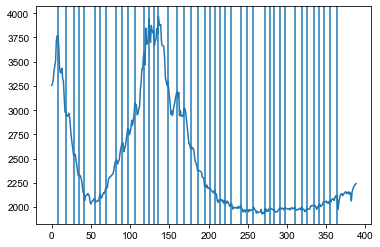

In [345]:
plt.plot(cell_df.dsred_mean)
for peak in raw_peaks:
    plt.axvline(peak)

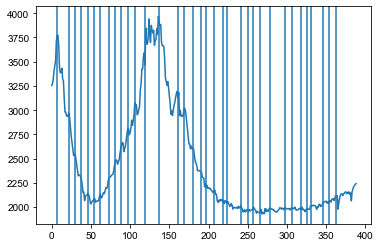

In [346]:
plt.plot(cell_df.dsred_mean)
for peak in filt_peaks:
    plt.axvline(peak)

In [ ]:
find_peak

In [333]:
fig.savefig('all_cells_kernel_scan_norm_delta.png')

In [321]:
all_peaks_df = pd.concat(peaks_dfs, ignore_index=True)

In [322]:
all_peaks_df

,cell_index,peak_indices,local_mean_kern,filt_kern,n_peaks,delta
0,0,11,15,3,28,3
1,0,18,15,3,28,3
2,0,28,15,3,28,3
3,0,37,15,3,28,3
4,0,46,15,3,28,3
...,...,...,...,...,...,...
13401,10,131,49,9,9,-9
13402,10,148,49,9,9,-9
13403,10,163,49,9,9,-9
13404,10,177,49,9,9,-9


In [243]:
threshold = 0.1
peak_indices, peak_dict = find_peaks(cell_df.local_mean_norm_medfilt_3,
                                         distance=6, threshold=threshold)
peak_indices = peak_indices[peak_indices <= np.max(manual_bud_indices)]

peak_indices

array([], dtype=int64)

In [246]:
height = 1.0
peak_indices, peak_dict = find_peaks(cell_df.local_mean_norm_medfilt_3,
                                         distance=6, height=height)
peak_indices = peak_indices[peak_indices <= np.max(manual_bud_indices)]

peak_indices

array([  7,  22,  73,  81,  89,  97, 119, 137, 161, 169, 180, 207, 224,
       241, 257, 278, 297, 307, 318, 331, 346, 353, 363], dtype=int64)

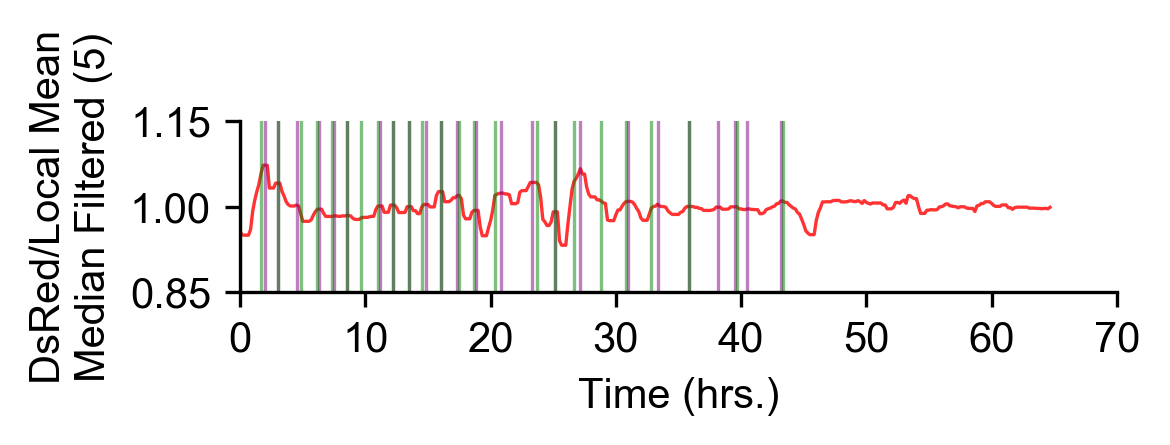

In [120]:
ax4kwargs = {'tracecolor': 'red',
          'ylabel': f'DsRed/Local Mean\nMedian Filtered ({meanfilt_kern})',
          'xlim': (0, 70),
          'ylim': (0.85, 1.15)}

ax4 = plotting.plot_fluor_trace(cell_df, f'local_mean_norm_medfilt_{meanfilt_kern}', 111,
                                **ax4kwargs)
for frame in peak_indices:
    x_value = (frame*10)/60
    if x_value <= np.max((manual_bud_indices*10)/60):
        ax4.axvline(x_value, color='purple', alpha=0.5, linewidth=0.8)
        
for frame in manual_bud_indices:
    ax4.axvline((frame*10)/60, color='green', alpha=0.5, linewidth=0.8)